In [406]:
import sys
sys.path.append("..")

import Essentials

In [407]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [408]:
data_archive = np.load('../Data_Average.npz', allow_pickle=True)

In [409]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [410]:
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']

In [411]:
x_train, x_test, y_train, y_test = train_test_split(all_X_2, all_Y_2, test_size=0.3, random_state=42)

In [412]:
all_X_2.shape

(110, 46)

In [413]:
y_train, timestamp_train = prepare_Y(y_train)

In [414]:
y_test, timestamp_test = prepare_Y(y_test)

In [415]:
x_train.shape

(77, 46)

In [416]:
x_test.shape

(33, 46)

In [417]:
x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_2, y_winter_half_2, test_size=0.2, random_state=42)

In [418]:
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_2, y_summer_half_2, test_size=0.2, random_state=42)

In [419]:
y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)

In [420]:
y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)

In [421]:
y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)

In [422]:
y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)

In [423]:
class PCA_LR(Essentials.SoftSensor):
    def __init__(self, name, x_train, y_train):
        super().__init__(name)
        self.x_scaler = StandardScaler()
        self.x_pca = PCA(n_components=0.95)
        self.fit_scaler(x_train)
        self.fit_pca(x_train)
        # self.max_components = min(x_train.shape[1], x_train.shape[0])
        # self.tune_pca_components(x_train, y_train, x_test, y_test)
        self.model = LinearRegression()
        self.train(x_train, y_train)
        self.set_model(self.model)

    # def tune_pca_components(self, x_train, y_train, x_test, y_test):
    #     for n_components in range(1, self.max_components + 1):
    #         pca = PCA(n_components=n_components)
    #         self.fit_pca(pca, x_train)
    #         pca_x_train = self.preprocessing(x_train)

    #         # Обучение модели
    #         model = LinearRegression()
    #         model.fit(pca_x_train, y_train)

    #         # предсказание на тестовой выборке
    #         pca_x_test = self.preprocessing(x_test)
    #         y_pred = model.predict(pca_x_test)

    #         # Расчёт R^2 и обновление списка r2_scores
    #         r2 = r2_score(y_test, y_pred)
    #         self.r2_scores.append(r2)

    #     # Определение оптимального числа компонент
    #     optimal_n_components = np.argmax(self.r2_scores) + 1
    #     print(f"Оптимальное количество главных компонент: {optimal_n_components}")

    #     # Обучение PCA с оптимальным числом компонент
    #     self.x_pca = PCA(n_components=optimal_n_components)
    #     self.x_pca.fit(self.x_scaler.transform(x_train))
    
    def preprocessing(self, x):
        try:
            x_scaled = self.x_scaler.transform(x)
            return self.x_pca.transform(x_scaled)
        except BaseException as err:
            print("Ошибка скейлера")
            raise err    
    
    def postprocessing(self, x):
        return x

    def fit_scaler(self, x):
        self.x_scaler.fit(x)

    def fit_pca(self, x):
        scaled_x = self.x_scaler.transform(x)
        self.x_pca.fit(scaled_x)
    
    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions

    def train(self, x_train, y_train):
        pca_x = self.preprocessing(x_train)
        self.model.fit(pca_x,y_train)

    def __str__(self):
        coef_lines = [f"Коэффициент {i + 1}: {coef:.6f}" for i, coef in enumerate(self.model.coef_.flatten())]
        coef_str = '\n'.join(coef_lines)
        intercept = self.model.intercept_
        if isinstance(intercept, np.ndarray):
            intercept = intercept.item(0)
        return f"{coef_str}\nСвободный член (intercept): {intercept:.6f}" 

In [424]:
PCA_LR_test = PCA_LR("PCA_LR" ,x_train ,y_train)

In [425]:
metric = Essentials.R2Metric()

In [426]:
print(PCA_LR_test)

Коэффициент 1: -1.087432
Коэффициент 2: -0.992986
Коэффициент 3: -1.167741
Коэффициент 4: 0.378139
Коэффициент 5: 0.438323
Коэффициент 6: -0.205406
Коэффициент 7: -0.041212
Коэффициент 8: -0.957916
Коэффициент 9: 0.227728
Коэффициент 10: 0.695029
Коэффициент 11: 1.345259
Коэффициент 12: 0.018493
Коэффициент 13: -1.165231
Коэффициент 14: -0.067923
Коэффициент 15: -1.311721
Коэффициент 16: 0.839167
Свободный член (intercept): 89.551948


In [427]:
PCA_LR_test.test(x_test, y_test, metric)

(array([[ 90.8742727 ],
        [ 77.68227899],
        [ 84.51730736],
        [ 94.65462858],
        [ 87.97018441],
        [ 84.34326864],
        [ 95.30768342],
        [ 90.07655289],
        [ 89.32413716],
        [ 80.02056733],
        [ 89.13903966],
        [ 89.3234681 ],
        [ 98.71923634],
        [ 92.7259411 ],
        [ 82.13406501],
        [ 84.30283501],
        [ 89.62488023],
        [ 84.47503513],
        [103.20729554],
        [ 91.17359763],
        [ 78.70611036],
        [ 99.58641647],
        [ 85.48512064],
        [ 98.41016375],
        [103.46218585],
        [ 99.11010573],
        [ 93.98762638],
        [ 88.18645546],
        [ 85.84731762],
        [ 88.75782853],
        [ 91.56832418],
        [ 89.99535731],
        [ 82.10042729]]),
 0.3404523999161928)

In [428]:
PCA_LR_test_visual_train = Essentials.Visualizer(x_train, y_train, timestamp_train, [metric], 'Linear with PCA SoftSensor R2 metric on Train')

        Coefficient of determination
PCA_LR                      0.433599


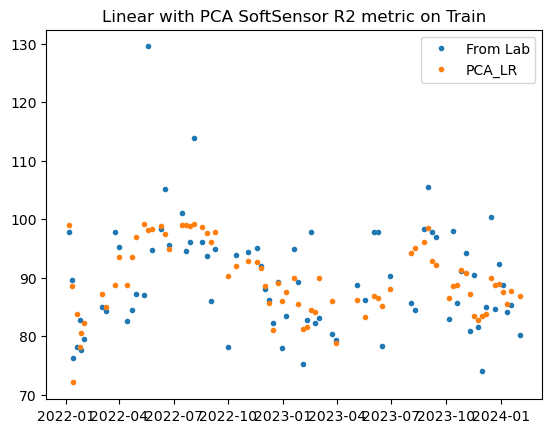

In [429]:
PCA_LR_test_visual_train.visualize([PCA_LR_test])

In [430]:
PCA_LR_test_visual_test = Essentials.Visualizer(x_test, y_test, timestamp_test, [metric], 'Linear with PCA SoftSensor R2 metric on Test')

        Coefficient of determination
PCA_LR                      0.340452


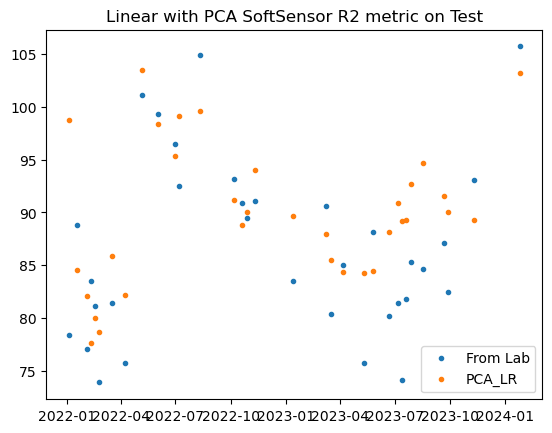

In [431]:
PCA_LR_test_visual_test.visualize([PCA_LR_test])